# First let's make a simple version of the two component binding model

In [6]:
import pymc
from glob import glob
import numpy as np


In [7]:
DG_min = np.log(1e-15) # kT, most favorable (negative) binding free energy possible; 1 fM
DG_max = +0 # kT, least favorable binding free energy possible

In [8]:
#this is just for the lognormal wrapper and inner filter effect and run_mcmc
from assaytools import pymcmodels

In [9]:
class BindingModel(object):
    """
    Abstract base class for reaction models.
    """

    def __init__(self):
        pass

In [5]:
class TwoComponentBindingModel(BindingModel):
   """
   Simple two-component association.
   """

   @classmethod
   def equilibrium_concentrations(cls, DeltaG, Ptot, Ltot):
      """
      Compute equilibrium concentrations for simple two-component association.
      Parameters
      ----------
      DeltaG : float
         Reduced free energy of binding (in units of kT)
      Ptot : float or numpy array
         Total protein concentration summed over bound and unbound species, molarity.
      Ltot : float or numpy array
         Total ligand concentration summed over bound and unbound speciesl, molarity.
      Returns
      -------
      P : float or numpy array with same dimensions as Ptot
         Free protein concentration, molarity.
      L : float or numpy array with same dimensions as Ptot
         Free ligand concentration, molarity.
      PL : float or numpy array with same dimensions as Ptot
         Bound complex concentration, molarity.
      """
      # Handle only strictly positive elements---all others are set to zero as constants
      try:
          nonzero_indices = np.where(Ltot > 0)[0]
          zero_indices = np.where(Ltot <= 0)[0]
      except:
          nonzero_indices = range(size[0])
          zero_indices = []
      nnonzero = len(nonzero_indices)
      nzeros = len(zero_indices)

      # Original form:
      #Kd = np.exp(DeltaG)
      #sqrt_arg = (Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot
      #sqrt_arg[sqrt_arg < 0.0] = 0.0
      #PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt(sqrt_arg));  # complex concentration (M)


      # Numerically stable variant?
      PL = np.zeros(Ptot.shape)
      logP = np.log(Ptot[nonzero_indices])
      logL = np.log(Ltot[nonzero_indices])
      logPLK = np.logaddexp(np.logaddexp(logP, logL), DeltaG)
      PLK = np.exp(logPLK);
      sqrt_arg = 1.0 - np.exp(np.log(4.0) + logP + logL - 2*logPLK);
      sqrt_arg[sqrt_arg < 0.0] = 0.0 # ensure always positive
      PL[nonzero_indices] = 0.5 * PLK * (1.0 - np.sqrt(sqrt_arg));  # complex concentration (M)

      # Another variant
      #PL = 2*Ptot*Ltot / ((Ptot+Ltot+Kd) + np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot));  # complex concentration (M)
      # Yet another numerically stable variant?
      #logPLK = np.logaddexp(np.log(Ptot + Ltot),  DeltaG);
      #PLK = np.exp(logPLK);
      #xy = np.exp(np.log(Ptot) + np.log(Ltot) - 2.0*logPLK);
      #chi = 1.0 - 4.0 * xy;
      #chi[chi < 0.0] = 0.0 # prevent square roots of negative numbers
      #PL = 0.5 * PLK * (1 - np.sqrt(chi))

      # Ensure all concentrations are within limits, correcting cases where numerical issues cause problems.
      PL[PL < 0.0] = 0.0 # complex cannot have negative concentration
      #PL_max = np.minimum(Ptot, Ltot)
      #indices = np.where(PL > PL_max)
      #PL[indices] = PL_max[indices]

      # Compute remaining concentrations.
      P = Ptot - PL; # free protein concentration in sample cell after n injections (M)
      L = Ltot - PL; # free ligand concentration in sample cell after n injections (M)
      return [P, L, PL]


In [6]:
#This is significantly simplified to remove if statements and only focus on top fluorescence
def make_model(Pstated, dPstated, Lstated, dLstated,
               top_complex_fluorescence=None, top_ligand_fluorescence=None,
               DG_prior='uniform',
               concentration_priors='lognormal',
               quantum_yield_priors='lognormal',
               use_primary_inner_filter_correction=True,
               use_secondary_inner_filter_correction=True,
               assay_volume=100e-6, well_area=0.1586,
               epsilon_ex=None, depsilon_ex=None,
               epsilon_em=None, depsilon_em=None,
               ligand_ex_absorbance=None, ligand_em_absorbance=None,
               F_PL=None, dF_PL=None):
    
     # Compute path length.
    path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections

    # Compute number of samples.
    N = len(Lstated)

    # Check input.
    # TODO: Check fluorescence and absorbance measurements for correct dimensions.
    if (len(Pstated) != N):
        raise Exception('len(Pstated) [%d] must equal len(Lstated) [%d].' % (len(Pstated), len(Lstated)))
    if (len(dPstated) != N):
        raise Exception('len(dPstated) [%d] must equal len(Lstated) [%d].' % (len(dPstated), len(Lstated)))
    if (len(dLstated) != N):
        raise Exception('len(dLstated) [%d] must equal len(Lstated) [%d].' % (len(dLstated), len(Lstated)))

    # Note whether we have top or bottom fluorescence measurements.
    top_fluorescence = (top_complex_fluorescence is not None) or (top_ligand_fluorescence is not None) # True if any top fluorescence measurements provided

    # Create an empty dict to hold the model.
    model = dict()
    
     # Prior on binding free energies.
    if DG_prior == 'uniform':
        DeltaG = pymc.Uniform('DeltaG', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    elif DG_prior == 'chembl':
        DeltaG = pymc.Normal('DeltaG', mu=0, tau=1./(12.5**2)) # binding free energy (kT), using a Gaussian prior inspured by ChEMBL
    else:
        raise Exception("DG_prior = '%s' unknown. Must be one of 'uniform' or 'chembl'." % DG_prior)
    # Add to model.
    model['DeltaG'] = DeltaG

    # Create priors on true concentrations of protein and ligand.
    if concentration_priors != 'lognormal':
        raise Exception("concentration_priors = '%s' unknown. Must be one of ['lognormal']." % concentration_priors)
    model['log_Ptrue'], model['Ptrue'] = pymcmodels.LogNormalWrapper('Ptrue', mean=Pstated, stddev=dPstated, size=Pstated.shape) # protein concentration (M)
    model['log_Ltrue'], model['Ltrue'] = pymcmodels.LogNormalWrapper('Ltrue', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration (M)
    model['log_Ltrue_control'], model['Ltrue_control'] = pymcmodels.LogNormalWrapper('Ltrue_control', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration in ligand-only wells (M)

    # extinction coefficient
    model['epsilon_ex'] = 0.0
    if use_primary_inner_filter_correction:
        if epsilon_ex:
            model['log_epsilon_ex'], model['epsilon_ex'] =  pymcmodels.LogNormalWrapper('epsilon_ex', mean=epsilon_ex, stddev=depsilon_ex) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_ex'] = pymc.Uniform('epsilon_ex', lower=0.0, upper=1000e3, value=70000.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    model['epsilon_em'] = 0.0
    if use_secondary_inner_filter_correction:
        if epsilon_em:
            model['log_epsilon_em'], model['epsilon_em'] =  pymcmodels.LogNormalWrapper('epsilon_em', mean=epsilon_em, stddev=depsilon_em) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_em'] = pymc.Uniform('epsilon_em', lower=0.0, upper=1000e3, value=0.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    # Min and max observed fluorescence.
    Fmax = 0.0; Fmin = 1e6;
    if top_complex_fluorescence is not None:
        Fmax = max(Fmax, top_complex_fluorescence.max()); Fmin = min(Fmin, top_complex_fluorescence.min())
    if top_ligand_fluorescence is not None:
        Fmax = max(Fmax, top_ligand_fluorescence.max()); Fmin = min(Fmin, top_ligand_fluorescence.min())

    # Compute initial guesses for fluorescence quantum yield quantities.
    F_plate_guess = Fmin
    F_buffer_guess = Fmin / path_length
    F_L_guess = (Fmax - Fmin) / Lstated.max()
    F_P_guess = Fmin
    F_P_guess = Fmin / Pstated.min()
    F_PL_guess = (Fmax - Fmin) / min(Pstated.max(), Lstated.max())

    # Priors on fluorescence intensities of complexes (later divided by a factor of Pstated for scale).

    if quantum_yield_priors == 'lognormal':
        stddev = 1.0 # relative factor for stddev guess
        model['log_F_plate'], model['F_plate'] =  pymcmodels.LogNormalWrapper('F_plate', mean=F_plate_guess, stddev=stddev*F_plate_guess) # plate fluorescence
        model['log_F_buffer'], model['F_buffer'] =  pymcmodels.LogNormalWrapper('F_buffer', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        model['log_F_buffer_control'], model['F_buffer_control'] =  pymcmodels.LogNormalWrapper('F_buffer_control', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        if (F_PL is not None) and (dF_PL is not None):
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL, stddev=dF_PL)
        else:
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL_guess, stddev=stddev*F_PL_guess) # complex fluorescence
        model['log_F_P'], model['F_P'] =  pymcmodels.LogNormalWrapper('F_P', mean=F_P_guess, stddev=stddev*F_P_guess) # protein fluorescence
        model['log_F_L'], model['F_L'] =  pymcmodels.LogNormalWrapper('F_L', mean=F_L_guess, stddev=stddev*F_L_guess) # ligand fluorescence
    else:
        raise Exception("quantum_yield_priors = '%s' unknown. Must be one of ['lognormal', 'uniform']." % quantum_yield_priors)

    # Unknown experimental measurement error.
    if top_fluorescence:
        model['log_sigma_top'] = pymc.Uniform('log_sigma_top', lower=-10, upper=np.log(Fmax), value=np.log(5))
        model['sigma_top'] = pymc.Lambda('sigma_top', lambda log_sigma=model['log_sigma_top'] : np.exp(log_sigma) )
        model['precision_top'] = pymc.Lambda('precision_top', lambda log_sigma=model['log_sigma_top'] : np.exp(-2*log_sigma) )

    if top_fluorescence:
        model['log_sigma_abs'] = pymc.Uniform('log_sigma_abs', lower=-10, upper=0, value=np.log(0.01))
        model['sigma_abs'] = pymc.Lambda('sigma_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(log_sigma) )
        model['precision_abs'] = pymc.Lambda('precision_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(-2*log_sigma) )

    if top_complex_fluorescence is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], DeltaG=model['DeltaG'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            [P_i, L_i, PL_i] = TwoComponentBindingModel.equilibrium_concentrations(DeltaG, Ptrue[:], Ltrue[:])
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data

    if top_ligand_fluorescence is not None:
        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
        
            # Promote this to a full-fledged PyMC model.
    pymc_model = pymc.Model(model)

    # Return the pymc model
    return pymc_model

In [16]:
from assaytools import parser

In [8]:
inputs = {
    'xml_file_path' :  "../fluorescence-assay-manuscript/data/singlet/",
    'file_set'      :  {'p38': glob( "../fluorescence-assay-manuscript/data/singlet/p38_8lig*.xml")},
    'section'       :  '280_480_TOP_120',
    'ligand_order'  :  ['Bosutinib','Bosutinib Isomer','Erlotinib','Gefitinib','Ponatinib','Lapatinib','Saracatinib','Vandetanib'],
    'Lstated'       :  np.array([20.0e-6,14.0e-6,9.82e-6,6.88e-6,4.82e-6,3.38e-6,2.37e-6,1.66e-6,1.16e-6,0.815e-6,0.571e-6,0.4e-6,0.28e-6,0.196e-6,0.138e-6,0.0964e-6,0.0676e-6,0.0474e-6,0.0320e-6,0.0240e-6,0.0160e-6,0.0120e-6,0.008e-6,0.0], np.float64), # ligand concentration, M
    'Pstated'       :  0.5e-6 * np.ones([24],np.float64), # protein concentration, M
    'assay_volume'  :  50e-6, # assay volume, L
    'well_area'     :  0.1369, # well area, cm^2 for 4ti-0203 [http://4ti.co.uk/files/3113/4217/2464/4ti-0201.pdf]
    }

In [9]:
[complex_fluorescence, ligand_fluorescence] = parser.get_data_using_inputs(inputs)  

In [10]:
dPstated = 0.35 * inputs['Pstated'] # protein concentration uncertainty
dLstated = 0.08 * inputs['Lstated'] # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [11]:
name = 'p38-Bosutinib-AB'

In [12]:
pymc_model = make_model(inputs['Pstated'], dPstated, inputs['Lstated'], dLstated,
    top_complex_fluorescence=complex_fluorescence[name],
    top_ligand_fluorescence=ligand_fluorescence[name],
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=inputs['assay_volume'], DG_prior='uniform')

In [13]:
mcmc = pymcmodels.run_mcmc(pymc_model)

In [10]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


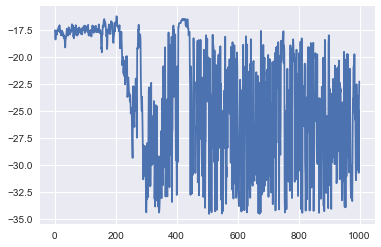

In [15]:
plt.plot(mcmc.DeltaG.trace())

# Now let's try a comparatively simple version of the competition binding modeling

In [11]:
class CompetitionBindingModel(BindingModel):
    """
     Analytic solution for competitive binding model problem.
     As described in Wang, Z. X. An exact mathematical expression 
     for describing competitive binding of two different ligands to 
     a protein molecule. FEBS Lett. 1995, 360, 111−114.
     """

    @classmethod
    def equilibrium_concentrations(cls, Ptot, Ltot, DeltaG_L, Btot, DeltaG_B):
        """
        Compute equilibrium concentrations for analytical competition assay association.
        Parameters
        ----------     
        Ptot : float or numpy array
          Total protein concentration summed over bound and unbound species, molarity.
        Ltot : float or numpy array
           Total fluorescent ligand concentration summed over bound and unbound speciesl, molarity.
        DeltaG_L : float
           Reduced free energy of binding of fluorescent L to P (in units of kT)
        Btot : float or numpy array
           Total competitive non-fluorescent ligand concentration summed over bound and unbound speciesl, molarity.
        DeltaG_B : float
           Reduced free energy of binding of non-fluorescent B to P (in units of kT)
        
        Returns
        -------
        P : float or numpy array with same dimensions as Ptot
           Free protein concentration, molarity.
        L : float or numpy array with same dimensions as Ptot
           Free fluorescent ligand concentration, molarity.
        PL : float or numpy array with same dimensions as Ptot
           Bound fluorescent ligand complex concentration, molarity.
        B : float or numpy array with same dimensions as Ptot
           Free non-fluorescent competitive ligand concentration, molarity.
        PB : float or numpy array with same dimensions as Ptot
           Bound non-fluorescent competitive ligand complex concentration, molarity.
        """
     
        # Handle only strictly positive elements---all others are set to zero as constants
        try:
            nonzero_indices = np.where(Ltot > 0)[0]
            zero_indices = np.where(Ltot <= 0)[0]
        except:
            nonzero_indices = range(size[0])
            zero_indices = []
        nnonzero = len(nonzero_indices)
        nzeros = len(zero_indices)

        # Original form:
        Kd_L = np.exp(DeltaG_L)
        Kd_B = np.exp(DeltaG_B)

        # P^3 + aP^2 + bP + c = 0
        a = Kd_L + Kd_B + Ltot + Btot - Ptot
        b = Kd_L*Kd_B + Kd_B*(Ltot-Ptot) + Kd_B*(Btot - Ptot)
        c = -Kd_L*Kd_B*Ptot
    
        # Subsitute P=u-a/3
        # u^3 - qu - r = 0 where 
        q = (a**2)/3.0 - b
        r = (-2.0/27.0)*a**3 +(1.0/3.0)*a*b - c
    
        # Discriminant
        delta = (r**2)/4.0 -(q**3)/27.0
    
        # 3 roots. Physically meaningful root is u.
        theta = np.arccos((-2*(a**3)+9*a*b-27*c)/(2*sqrt((a**2-3*b)**3)))
        u = (2.0/3.0)*sqrt(a**2-3*b)*cos(theta/3.0)

        # Compute remaining concentrations.
        P = u - a/3.0           # free protein concentration in sample cell after n injections (M)
        PL = P*Ltot/(Kd_L + P)  # fluorescent ligand complex concentration (M)
        PB = P*Btot/(Kd_B + P)  # non-fluorescent ligand complex concentration (M)
        L = Ltot - PL           # free fluorescent ligand concentration in sample cell after n injections (M)
        B = Btot - PB           # free non-fluorescent ligand concentration in sample cell after n injections (M)
    
        return [P, L, PL, B, PB]



In [12]:
#This is our new competition assay model, which has competition as an option (note just for top fluroescence)
#if the values on the second line are included
def make_comp_model(Pstated, dPstated, Lstated, dLstated,
               Bstated = None, dBstated = None, DG_L_mean = None, DG_L_std = None, # specific for competition assay
               top_complex_fluorescence=None, top_ligand_fluorescence=None,
               DG_prior='uniform',
               concentration_priors='lognormal',
               quantum_yield_priors='lognormal',
               use_primary_inner_filter_correction=True,
               use_secondary_inner_filter_correction=True,
               assay_volume=100e-6, well_area=0.1586,
               epsilon_ex=None, depsilon_ex=None,
               epsilon_em=None, depsilon_em=None,
               ligand_ex_absorbance=None, ligand_em_absorbance=None,
               F_PL=None, dF_PL=None):

    # Compute path length.
    path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections

    # Compute number of samples.
    N = len(Lstated)
    
    # Check input.
    # TODO: Check fluorescence and absorbance measurements for correct dimensions.
    if (len(Pstated) != N):
        raise Exception('len(Pstated) [%d] must equal len(Lstated) [%d].' % (len(Pstated), len(Lstated)))
    if (len(dPstated) != N):
        raise Exception('len(dPstated) [%d] must equal len(Lstated) [%d].' % (len(dPstated), len(Lstated)))
    if (len(dLstated) != N):
        raise Exception('len(dLstated) [%d] must equal len(Lstated) [%d].' % (len(dLstated), len(Lstated)))

    # Note whether we have top or bottom fluorescence measurements.
    top_fluorescence = (top_complex_fluorescence is not None) or (top_ligand_fluorescence is not None) # True if any top fluorescence measurements provided

    # Create an empty dict to hold the model.
    model = dict()
    
    # Prior on binding free energies.
    if DG_prior == 'uniform':
        DeltaG_B = pymc.Uniform('DeltaG_B', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    elif DG_prior == 'chembl':
        DeltaG_B = pymc.Normal('DeltaG_B', mu=0, tau=1./(12.5**2)) # binding free energy (kT), using a Gaussian prior inspured by ChEMBL
    else:
        raise Exception("DG_prior = '%s' unknown. Must be one of 'uniform' or 'chembl'." % DG_prior)
    model['DeltaG_B'] = DeltaG_B
    
    # Prior on known binding free energy.
    if DG_L_mean == None:
        DeltaG_L = pymc.Uniform('DeltaG_L', lower=DG_min, upper=DG_max) # binding free energy (kT), uniform over huge range
    else:
        DeltaG_L = pymc.Normal('DeltaG_L', mu=DG_L_mean, tau=DG_L_std) 
    model['DeltaG_L'] = DeltaG_L
        
    if concentration_priors != 'lognormal':
        raise Exception("concentration_priors = '%s' unknown. Must be one of ['lognormal']." % concentration_priors)
    model['log_Ptrue'], model['Ptrue'] = pymcmodels.LogNormalWrapper('Ptrue', mean=Pstated, stddev=dPstated, size=Pstated.shape) # protein concentration (M)
    model['log_Ltrue'], model['Ltrue'] = pymcmodels.LogNormalWrapper('Ltrue', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration (M)
    model['log_Btrue'], model['Btrue'] = pymcmodels.LogNormalWrapper('Btrue', mean=Bstated, stddev=dBstated, size=Bstated.shape) # ligand concentration (M)
    model['log_Ltrue_control'], model['Ltrue_control'] = pymcmodels.LogNormalWrapper('Ltrue_control', mean=Lstated, stddev=dLstated, size=Lstated.shape) # ligand concentration in ligand-only wells (M)

    # extinction coefficient
    model['epsilon_ex'] = 0.0
    if use_primary_inner_filter_correction:
        if epsilon_ex:
            model['log_epsilon_ex'], model['epsilon_ex'] =  pymcmodels.LogNormalWrapper('epsilon_ex', mean=epsilon_ex, stddev=depsilon_ex) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_ex'] = pymc.Uniform('epsilon_ex', lower=0.0, upper=1000e3, value=70000.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    model['epsilon_em'] = 0.0
    if use_secondary_inner_filter_correction:
        if epsilon_em:
            model['log_epsilon_em'], model['epsilon_em'] =  pymcmodels.LogNormalWrapper('epsilon_em', mean=epsilon_em, stddev=depsilon_em) # prior is centered on measured extinction coefficient
        else:
            model['epsilon_em'] = pymc.Uniform('epsilon_em', lower=0.0, upper=1000e3, value=0.0) # extinction coefficient or molar absorptivity for ligand, units of 1/M/cm

    # Min and max observed fluorescence.
    Fmax = 0.0; Fmin = 1e6;
    if top_complex_fluorescence is not None:
        Fmax = max(Fmax, top_complex_fluorescence.max()); Fmin = min(Fmin, top_complex_fluorescence.min())
    if top_ligand_fluorescence is not None:
        Fmax = max(Fmax, top_ligand_fluorescence.max()); Fmin = min(Fmin, top_ligand_fluorescence.min())

    # Compute initial guesses for fluorescence quantum yield quantities.
    F_plate_guess = Fmin
    F_buffer_guess = Fmin / path_length
    F_L_guess = (Fmax - Fmin) / Lstated.max()
    F_P_guess = Fmin
    F_P_guess = Fmin / Pstated.min()
    F_PL_guess = (Fmax - Fmin) / min(Pstated.max(), Lstated.max())

    # Priors on fluorescence intensities of complexes (later divided by a factor of Pstated for scale).

    if quantum_yield_priors == 'lognormal':
        stddev = 1.0 # relative factor for stddev guess
        model['log_F_plate'], model['F_plate'] =  pymcmodels.LogNormalWrapper('F_plate', mean=F_plate_guess, stddev=stddev*F_plate_guess) # plate fluorescence
        model['log_F_buffer'], model['F_buffer'] =  pymcmodels.LogNormalWrapper('F_buffer', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        model['log_F_buffer_control'], model['F_buffer_control'] =  pymcmodels.LogNormalWrapper('F_buffer_control', mean=F_buffer_guess, stddev=stddev*F_buffer_guess) # buffer fluorescence
        if (F_PL is not None) and (dF_PL is not None):
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL, stddev=dF_PL)
        else:
            model['log_F_PL'], model['F_PL'] =  pymcmodels.LogNormalWrapper('F_PL', mean=F_PL_guess, stddev=stddev*F_PL_guess) # complex fluorescence
        model['log_F_P'], model['F_P'] =  pymcmodels.LogNormalWrapper('F_P', mean=F_P_guess, stddev=stddev*F_P_guess) # protein fluorescence
        model['log_F_L'], model['F_L'] =  pymcmodels.LogNormalWrapper('F_L', mean=F_L_guess, stddev=stddev*F_L_guess) # ligand fluorescence
    else:
        raise Exception("quantum_yield_priors = '%s' unknown. Must be one of ['lognormal', 'uniform']." % quantum_yield_priors)

    # Unknown experimental measurement error.
    if top_fluorescence:
        model['log_sigma_top'] = pymc.Uniform('log_sigma_top', lower=-10, upper=np.log(Fmax), value=np.log(5))
        model['sigma_top'] = pymc.Lambda('sigma_top', lambda log_sigma=model['log_sigma_top'] : np.exp(log_sigma) )
        model['precision_top'] = pymc.Lambda('precision_top', lambda log_sigma=model['log_sigma_top'] : np.exp(-2*log_sigma) )

    if top_fluorescence:
        model['log_sigma_abs'] = pymc.Uniform('log_sigma_abs', lower=-10, upper=0, value=np.log(0.01))
        model['sigma_abs'] = pymc.Lambda('sigma_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(log_sigma) )
        model['precision_abs'] = pymc.Lambda('precision_abs', lambda log_sigma=model['log_sigma_abs'] : np.exp(-2*log_sigma) )

    if top_complex_fluorescence is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'], DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            [P_i, L_i, PL_i, B_i, PB_i] = CompetitionBindingModel.equilibrium_concentrations(Ptrue[:], Ltrue[:], DeltaG_L, Btrue[:], DeltaG_B)
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data
        
    if top_ligand_fluorescence is not None:
        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
        
    #Below this is competition model stuff!    
    
    # Compute number of samples.
    if Bstated is not None:
        N_B = len(Bstated)

        # Check input.
        # TODO: Check fluorescence and absorbance measurements for correct dimensions.
        if (len(Lstated) != N_B):
            raise Exception('len(Lstated) [%d] must equal len(Bstated) [%d].' % (len(Lstated), len(Bstated)))
        if (len(Pstated) != N_B):
            raise Exception('len(Pstated) [%d] must equal len(Bstated) [%d].' % (len(Pstated), len(Bstated)))
        if (len(dPstated) != N_B):
            raise Exception('len(dPstated) [%d] must equal len(Bstated) [%d].' % (len(dPstated), len(Bstated)))
        if (len(dBstated) != N_B):
            raise Exception('len(dBstated) [%d] must equal len(Bstated) [%d].' % (len(dBstated), len(Bstated)))

            
    if Bstated is not None:
        @pymc.deterministic
        def top_complex_fluorescence_model(F_plate=model['F_plate'], F_buffer=model['F_buffer'],
                                           F_PL=model['F_PL'], F_P=model['F_P'], F_L=model['F_L'],
                                           Ptrue=model['Ptrue'], Ltrue=model['Ltrue'], Btrue=model['Btrue'],
                                           DeltaG_L=model['DeltaG_L'], DeltaG_B=model['DeltaG_B'],
                                           epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            [P_i, L_i, PL_i, B_i, PB_i] = CompetitionBindingModel.equilibrium_concentrations(Ptrue[:], Ltrue[:], DeltaG_L, Btrue[:], DeltaG_B)
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_i, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*L_i) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_complex_fluorescence_model'] = top_complex_fluorescence_model
        model['log_top_complex_fluorescence'], model['top_complex_fluorescence'] = pymcmodels.LogNormalWrapper('top_complex_fluorescence',
            mean=model['top_complex_fluorescence_model'], stddev=model['sigma_top'],
            size=[N], observed=True, value=top_complex_fluorescence) # observed data

        @pymc.deterministic
        def top_ligand_fluorescence_model(F_plate=model['F_plate'], F_buffer_control=model['F_buffer_control'],
                                          F_L=model['F_L'],
                                          Ltrue_control=model['Ltrue_control'],
                                          epsilon_ex=model['epsilon_ex'], epsilon_em=model['epsilon_em']):
            IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, Ltrue_control, geometry='top')
            IF_i_plate = np.exp(-(epsilon_ex+epsilon_em)*path_length*Ltrue_control) # inner filter effect applied only to plate
            Fmodel_i = IF_i[:]*(F_L*Ltrue_control + F_buffer_control*path_length) + IF_i_plate*F_plate
            return Fmodel_i
        # Add to model.
        model['top_ligand_fluorescence_model'] = top_ligand_fluorescence_model
        model['log_top_ligand_fluorescence'], model['top_ligand_fluorescence'] = pymcmodels.LogNormalWrapper('top_ligand_fluorescence',
                                                       mean=model['top_ligand_fluorescence_model'], stddev=model['sigma_top'],
                                                       size=[N], observed=True, value=top_ligand_fluorescence) # observed data
    # Promote this to a full-fledged PyMC model.
    pymc_model = pymc.Model(model)

    # Return the pymc model
    return pymc_model

In [13]:
inputs = {
    'xml_file_path' :  "/../assaytools/assaytools/examples/competition-fluorescence-assay/data/",
    'file_set'      :  {'Abl-IMA': glob("../assaytools/assaytools/examples/competition-fluorescence-assay/data/Abl*16-22-45_plate*.xml")},
    'ligand_order'  :  ['Gefitinib','Gefitinib','Gefitinib','Gefitinib'],
    'competitive_ligand'  :  'Imatinib',
    'section'       :  '280_BottomRead',
    'Lstated'       :  np.array([20.0e-6,9.15e-6,4.18e-6,1.91e-6,0.875e-6,0.4e-6,0.183e-6,0.0837e-6,0.0383e-6,0.0175e-6,0.008e-6,0.0], np.float64), # ligand concentration, M
    'Bstated'       :  10.0e-6 * np.ones([12],np.float64), # competitive ligand concentration, M
    'Pstated'       :  0.5e-6 * np.ones([12],np.float64), # protein concentration, M
    'assay_volume'  :  100e-6, # assay volume, L
    'well_area'     :  0.3969, # well area, cm^2 for 4ti-0203 [http://4ti.co.uk/files/3113/4217/2464/4ti-0201.pdf],
    'DG_L_mean'     :  -12.5, #DeltaG of Gefitinib mean estimate (kT)
    'DG_L_std'      :  1      #DeltaG of Gefitinib standard deviation estimate (kT)
    }

In [14]:
dPstated = 0.35 * inputs['Pstated'] # protein concentration uncertainty
dLstated = 0.08 * inputs['Lstated'] # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)
dBstated = 0.08 * inputs['Bstated'] # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [17]:
[complex_fluorescence_comp, ligand_fluorescence_comp] = parser.get_data_using_inputs(inputs)  

In [18]:
name = 'Abl-IMA-Gefitinib-AB'

In [19]:
pymc_comp_model = make_comp_model(inputs['Pstated'], dPstated, inputs['Lstated'], dLstated,
    inputs['Bstated'], dBstated, inputs['DG_L_mean'], inputs['DG_L_std'],# specific for competition assay
    top_complex_fluorescence=complex_fluorescence_comp[name],
    top_ligand_fluorescence=ligand_fluorescence_comp[name],
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=inputs['assay_volume'], DG_prior='uniform')

In [20]:
comp_mcmc = pymc.MCMC(pymc_comp_model)

In [35]:
#comp_mcmc = pymcmodels.run_mcmc(pymc_comp_model)
nburn = 500
niter = 50000
nthin = 20

In [36]:
comp_mcmc.sample(iter=(nburn+niter), burn=nburn, thin=nthin, progress_bar=False, tune_throughout=True)

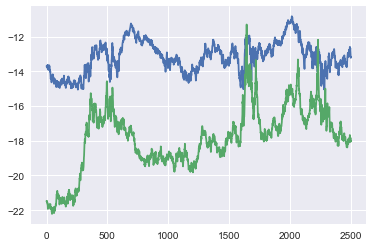

In [42]:
plt.plot(comp_mcmc.DeltaG_L.trace())
plt.plot(comp_mcmc.DeltaG_B.trace())


In [40]:
Abl_gefitinib = 2200e-9 # 2200 nM from DiscoverRx screen data 

AblGef_dG = np.log(Abl_gefitinib)

Abl_imatinib = 1.1e-9 # 1.1 nM from DiscoverRx screen data 

AblIma_dG = np.log(Abl_imatinib)

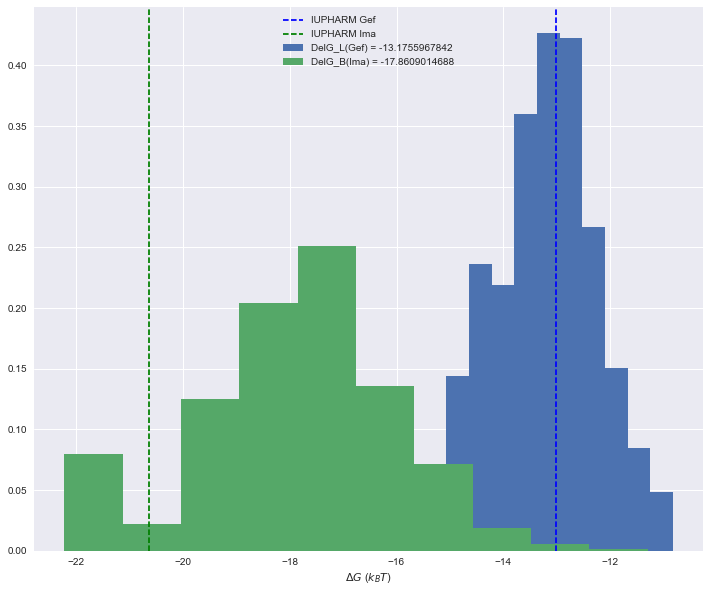

In [41]:
plt.figure(figsize=(12,10))
plt.hist(comp_mcmc.DeltaG_L.trace(),normed=True,label='DelG_L(Gef) = %s' %comp_mcmc.DeltaG_L.trace().mean());
plt.axvline(x=AblGef_dG,color='b',linestyle='--',label='IUPHARM Gef')
plt.hist(comp_mcmc.DeltaG_B.trace(),normed=True,label='DelG_B(Ima) = %s' %comp_mcmc.DeltaG_B.trace().mean());
plt.axvline(x=AblIma_dG,color='g',linestyle='--',label='IUPHARM Ima')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.legend(loc=0);